In [1]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
import ipympl
from scipy.spatial.transform import Rotation


%matplotlib widget

In [2]:
sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=True, direction="nearest", tolerance=0.001), dataframes)

    return df_merged

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=False)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

In [3]:
b = bagreader('/home/msccomputer/catkin_ws/src/out/rosbag/lab/outside_mission/mission_test3/2022-11-11-09-39-59.bag')

b.topic_table

[INFO]  Data folder /home/msccomputer/catkin_ws/src/out/rosbag/lab/outside_mission/mission_test3/2022-11-11-09-39-59 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,4180,32.165895
1,/anafi/gnss_location,sensor_msgs/NavSatFix,4180,32.451597
2,/anafi/gnss_ned_in_body_frame,geometry_msgs/PointStamped,4180,1244.970021
3,/anafi/gnss_ned_in_body_frame/1hz,geometry_msgs/PointStamped,134,0.967550
4,/anafi/height,olympe_bridge/Float32Stamped,4180,32.314586
5,/anafi/image,sensor_msgs/Image,4180,31.682862
6,/anafi/ned_pose_from_gnss,geometry_msgs/PointStamped,4180,32.294930
7,/anafi/odometry,nav_msgs/Odometry,4180,22.810875
8,/anafi/optical_flow_velocities,geometry_msgs/Vector3Stamped,4180,32.195029
9,/anafi/polled_body_velocities,geometry_msgs/TwistStamped,698,5.021056


In [4]:
def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def sync_dfs_based_on_time(dataframes: list):
    df_merged = reduce(lambda left,right: pd.merge_asof(left, right, on="Time", allow_exact_matches=False, direction="nearest"), dataframes)

    return df_merged


def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df, datacols_list, remove_identicals=True):
    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

### Calculate the OF velocity in body frame

In [5]:
# Load the anafi GT data attitude data
anafi_pose_NED = b.message_by_topic('/anafi/attitude')
df_anafi_pose_NED = pd.read_csv(anafi_pose_NED)

# Load the anafi gt velocity data
of_vel =  b.message_by_topic('/anafi/optical_flow_velocities')
df_of_vel = pd.read_csv(of_vel)
df_of_vel = drop_columns_in_df(df_of_vel)

df_of_vel = rename_columns(df_of_vel, ["of_x", "of_y", "of_z"])

# Sync the two dataframes based on timestamps
df_NED = sync_dfs_based_on_time([df_anafi_pose_NED, df_of_vel])

# Create the rotation objects and apply the rotations to the pose of the platform
df_rotation_NED_to_body = df_NED[["quaternion.x",	"quaternion.y",	"quaternion.z",	"quaternion.w"]]
rotation_NED_to_body = Rotation.from_quat(df_rotation_NED_to_body).inv()

# Get the anafi velocity in the body frame
anafi_vel_body = rotation_NED_to_body.apply(df_NED[["of_x", "of_y", "of_z"]])
df_anafi_vel_body = pd.DataFrame(anafi_vel_body)
df_anafi_vel_body.columns = ["of_x_body", "of_y_body", "of_z_body"]

conc = [df_NED, df_anafi_vel_body]

df_positions_body = pd.concat(
    conc,
    axis=1,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

df_of_vel_body = df_positions_body[["Time", "of_x", "of_y", "of_z"]]


In [6]:
polled_vel = b.message_by_topic('/anafi/polled_body_velocities')
df_polled_vel = pd.read_csv(polled_vel)

df_polled_vel = drop_columns_in_df(df_polled_vel)
df_polled_vel = rename_columns(df_polled_vel, ["polled_linear_x", "polled_linear_y", "polled_linear_z", "polled_angular_x", "polled_angular_y", "polled_angular_z"])


In [8]:
merged_frame = sync_dfs_based_on_time([df_of_vel_body, df_polled_vel])


df_merged_position = normalize_df_time(merged_frame)

of_data = get_np_arr_without_nan(df_merged_position, ["of_x", "of_y", "of_z"], remove_identicals=True)
polled_data = get_np_arr_without_nan(df_merged_position, ["polled_linear_x", "polled_linear_y", "polled_linear_z"], remove_identicals=True)

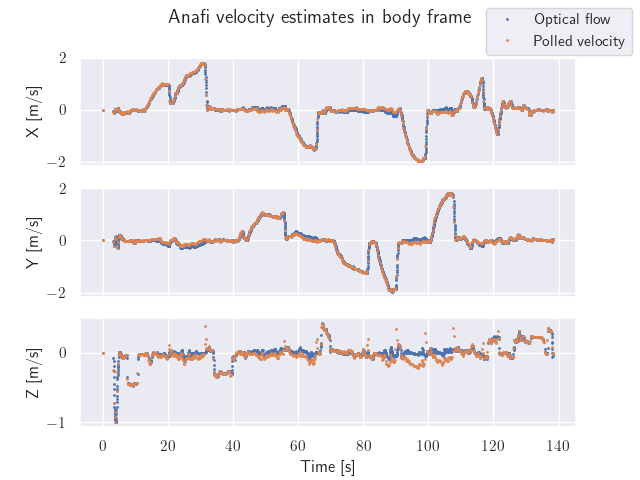

In [9]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(of_data[:,0], of_data[:,2], 'o', ms=1)
axs[0].plot(polled_data[:,0], polled_data[:,1], 'o', ms=1)

axs[0].set_xticklabels([])
axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)

axs[1].plot(of_data[:,0], -of_data[:,1], 'o', ms=1)
axs[1].plot(polled_data[:,0], polled_data[:,2], 'o', ms=1)


axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)

axs[2].plot(of_data[:,0], of_data[:,3], 'o', ms=1)
axs[2].plot(polled_data[:,0], polled_data[:,3], 'o', ms=1)


axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
labels = ["Optical flow", "Polled velocity"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Anafi velocity estimates in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()

## With ekf vel estimate

In [33]:
# Load the anafi GT data attitude data
ekf_vel = b.message_by_topic('/estimate/ekf/velocity')
df_ekf_vel = pd.read_csv(ekf_vel)

df_ekf_vel = drop_columns_in_df(df_ekf_vel)

df_ekf_vel = rename_columns(df_ekf_vel, ["vel_x", "vel_y", "vel_z"])

In [34]:
merged_frame = sync_dfs_based_on_time([df_gt_vel_body, df_polled_vel, df_ekf_vel])


df_merged_position = normalize_df_time(merged_frame)

gt_data = get_np_arr_without_nan(df_merged_position, ["anafi_vel_x_body", "anafi_vel_y_body", "anafi_vel_z_body"], remove_identicals=False)
ekf_vel = get_np_arr_without_nan(df_merged_position, ["vel_x", "vel_y", "vel_z"], remove_identicals=True)
polled_data = get_np_arr_without_nan(df_merged_position, ["polled_linear_x", "polled_linear_y", "polled_linear_z"], remove_identicals=True)

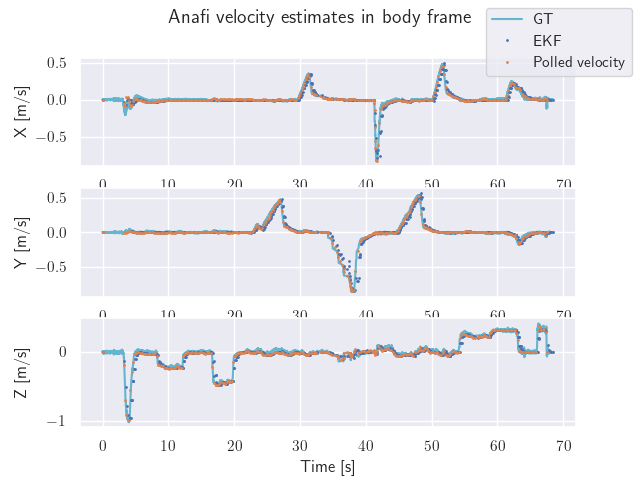

In [35]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(gt_data[:,0], gt_data[:,1], c='c')
axs[0].plot(ekf_vel[:,0], ekf_vel[:,1], 'o', ms=1)
axs[0].plot(polled_data[:,0], polled_data[:,1], 'o', ms=1)

# axs[0].set_xticklabels([])
axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)

axs[1].plot(gt_data[:,0], gt_data[:,2], c='c')
axs[1].plot(ekf_vel[:,0], ekf_vel[:,2], 'o', ms=1)
axs[1].plot(polled_data[:,0], polled_data[:,2], 'o', ms=1)


# axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)

axs[2].plot(gt_data[:,0], gt_data[:,3], c='c')
axs[2].plot(ekf_vel[:,0], ekf_vel[:,3], 'o', ms=1)
axs[2].plot(polled_data[:,0], polled_data[:,3], 'o', ms=1)


axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[0].get_legend_handles_labels()
labels = [ "GT", "EKF", "Polled velocity"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Anafi velocity estimates in body frame', fontsize=14)
fig.align_ylabels(axs)

plt.show()